In [2]:
#Import all libraries I need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score, plot_roc_curve, mean_absolute_error
from xgboost import XGBRegressor
from pdpbox.pdp import pdp_isolate, pdp_interact, pdp_interact_plot, pdp_plot

In [3]:
df = pd.read_csv('data/aac_intakes_outcomes.csv.zip',
                 parse_dates=['intake_datetime'], index_col='intake_datetime')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79672 entries, 2017-12-07 00:00:00 to 2018-03-29 18:20:00
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age_upon_outcome            79672 non-null  object 
 1   animal_id_outcome           79672 non-null  object 
 2   date_of_birth               79672 non-null  object 
 3   outcome_subtype             36348 non-null  object 
 4   outcome_type                79662 non-null  object 
 5   sex_upon_outcome            79671 non-null  object 
 6   age_upon_outcome_(days)     79672 non-null  int64  
 7   age_upon_outcome_(years)    79672 non-null  float64
 8   age_upon_outcome_age_group  79672 non-null  object 
 9   outcome_datetime            79672 non-null  object 
 10  outcome_month               79672 non-null  int64  
 11  outcome_year                79672 non-null  int64  
 12  outcome_monthyear           79672 non-null  object 
 

Plot all numerical variables with age upon intake as well as seeing if what day the animal was brought in has a factor 

Text(0, 0.5, 'Type of Animal')

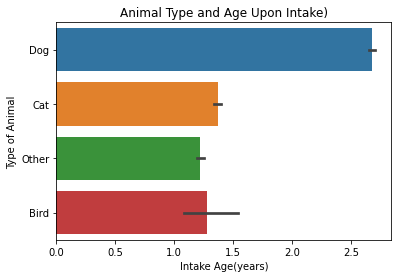

In [5]:
#`age_upon-intake` and `animal_type`

sns.barplot(x=df['age_upon_intake_(years)'],
           y=df['animal_type'])
plt.title('Animal Type and Age Upon Intake)')
plt.xlabel('Intake Age(years)')
plt.ylabel('Type of Animal')

In [6]:
df['animal_type'].value_counts(normalize=True)

Dog      0.569410
Cat      0.370758
Other    0.055578
Bird     0.004255
Name: animal_type, dtype: float64

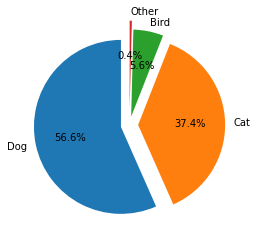

In [7]:
#Types od animals in the shelter
label= 'Dog', 'Cat', 'Bird', 'Other'
size= [56, 37, 5.5, .4]
expand= (0.1, 0.1, 0.1, 0.2)
fig, ax = plt.subplots()
ax.pie(size, explode=expand, labels=label, autopct='%1.1f%%', startangle=90)
plt.show()

In [8]:
df['outcome_subtype'].value_counts()

Partner                19840
Foster                  5490
SCRP                    3205
Suffering               2549
Rabies Risk             2539
Snr                      752
Aggressive               497
In Kennel                351
Offsite                  350
Medical                  265
In Foster                177
Behavior                 133
At Vet                    71
Enroute                   49
Underage                  28
Court/Investigation       23
In Surgery                17
Possible Theft             9
Barn                       3
Name: outcome_subtype, dtype: int64

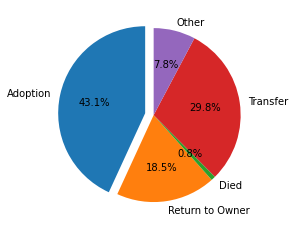

In [9]:
labels = 'Adoption', 'Return to Owner', 'Died', 'Transfer', 'Other'
wedge = [42, 18, 0.8, 29, 7.56]
explode = (.1, 0, 0, 0, 0)
fig, ax=plt.subplots()
ax.pie(wedge, explode=explode, labels=labels, data=df['outcome_type'], autopct='%1.1f%%',
       startangle=90)
plt.show()

In [10]:
df['animal_id_intake'].value_counts()

A721033    13
A718223    11
A706536    11
A738324     8
A616444     8
           ..
A710916     1
A666260     1
A683234     1
A665121     1
A690818     1
Name: animal_id_intake, Length: 71961, dtype: int64

In [11]:
dup_row = df.duplicated(subset='animal_id_intake', keep='first')
dup_row

intake_datetime
2017-12-07 00:00:00    False
2014-12-19 10:21:00     True
2014-03-07 14:26:00     True
2014-04-02 15:55:00    False
2013-11-16 09:02:00    False
                       ...  
2018-03-29 16:23:00    False
2018-03-29 17:13:00    False
2018-03-29 17:19:00    False
2018-03-29 18:19:00    False
2018-03-29 18:20:00    False
Length: 79672, dtype: bool

In [12]:
#Creating wrangle function
def wrangle(filepath):
    df = pd.read_csv(filepath, parse_dates=['intake_datetime'], index_col='intake_datetime')
    
    #drop duplicated rows
    df.drop_duplicates(keep='first', inplace=True)
    
    #drop columns that are highly correlated with other columns
    df.drop(columns=['outcome_subtype', 'count', 'age_upon_outcome_age_group', 'age_upon_outcome_(days)', 'age_upon_intake_age_group',
                     'dob_year', 'age_upon_intake_(days)', 'outcome_hour'], inplace=True)
    
    #drop high cardinallity variables
    high_car = [col for col in df.select_dtypes('object').columns if df[col].nunique() > 50]
    df.drop(columns=high_car, inplace=True)
    
    dupe_cols = df.columns[df.head(20).T.duplicated()]
    df.drop(columns=dupe_cols, inplace=True)
    
    return df

In [13]:
d = wrangle('data/aac_intakes_outcomes.csv.zip')

In [14]:
d.shape

(79637, 16)

In [15]:
d.head()

,age_upon_outcome,outcome_type,sex_upon_outcome,age_upon_outcome_(years),outcome_month,outcome_year,outcome_weekday,outcome_number,dob_month,animal_type,intake_condition,intake_type,intake_month,intake_weekday,intake_hour,time_in_shelter_days
intake_datetime,,,,,,,,,,,,,,,,
2017-12-07 00:00:00,10 years,Return to Owner,Neutered Male,10.0,12,2017,Thursday,1.0,7,Dog,Normal,Stray,12,Thursday,14,0.588194
2014-12-19 10:21:00,7 years,Return to Owner,Neutered Male,7.0,12,2014,Saturday,2.0,7,Dog,Normal,Public Assist,12,Friday,10,1.259722
2014-03-07 14:26:00,6 years,Return to Owner,Neutered Male,6.0,3,2014,Saturday,3.0,7,Dog,Normal,Public Assist,3,Friday,14,1.113889
2014-04-02 15:55:00,10 years,Transfer,Neutered Male,10.0,4,2014,Monday,1.0,4,Dog,Normal,Owner Surrender,4,Wednesday,15,4.970139
2013-11-16 09:02:00,16 years,Return to Owner,Neutered Male,16.0,11,2013,Saturday,1.0,10,Dog,Injured,Public Assist,11,Saturday,9,0.119444


# Split data

In [25]:
target = 'age_upon_outcome_(years)'
y = d[target]
X = d.drop(columns=target)

In [26]:
X_train, y_train = X[:-16000], y[:-16000]
X_val, y_val = X[-16000: -8000], y[-16000: -8000]
X_test, y_test = X[-8000:], y[-8000:]

In [27]:
print('Baseline:', y_train.value_counts(normalize=True).max())

Baseline: 0.1823310338325188


In [28]:
#Create model 
model_gb = make_pipeline(OneHotEncoder(),
                         XGBRegressor(random_state=42, n_jobs=-1))
model_rf = make_pipeline(OneHotEncoder(),
                         RandomForestRegressor(random_state=42, n_jobs=-1))
model_r = make_pipeline(OneHotEncoder(),
                        Ridge())

In [29]:
#Fit the model using training data
model_gb.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_r.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['age_upon_outcome', 'outcome_type',
                                     'sex_upon_outcome', 'outcome_weekday',
                                     'animal_type', 'intake_condition',
                                     'intake_type', 'intake_weekday'])),
                ('ridge', Ridge())])

In [30]:
#Check metrics
print('Training MAE GB:', mean_absolute_error(y_train, model_gb.predict(X_train)))
print('Validation MAE GB:', mean_absolute_error(y_val, model_gb.predict(X_val)))
print('Training MAE RF:', mean_absolute_error(y_train, model_rf.predict(X_train)))
print('Validation MAE RF:', mean_absolute_error(y_val, model_rf.predict(X_val)))
print('Training MAE R:', mean_absolute_error(y_train, model_r.predict(X_train)))
print('Validation MAE R:', mean_absolute_error(y_val, model_r.predict(X_val)))

Training MAE GB: 0.019191462507514395
Validation MAE GB: 0.022630737750446554
Training MAE RF: 0.00020816097122857344
Validation MAE RF: 7.477887666723637e-16
Training MAE R: 0.007648218620069714
Validation MAE R: 0.008038607062517723


## Tuning my model 

With these params `params = {'ridge__alpha': (1.5, 2.0, 2.5),
         'ridge__max_iter': (200, 250, 300),
         'ridge__solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}`
The best out of those are: `alpha = 1.5, max_iter=200, solver = svd`

With these params `params = {'ridge__alpha': (1.25, 1.5, 1.75),
         'ridge__max_iter': (150, 175, 195),
         'ridge__solver':['svd']}`
The best out of those are: `alpha = 1.25, max_iter=150 , solver=svd`
**Keeping solver the same**
With these params: `params = {'ridge__alpha': (1.0, 1.15, 1.25),
         'ridge__max_iter': (120, 130, 140),
         'ridge__solver':['svd']}`
         
The best out of those are: `alpha=1 , max_iter=120`

In [31]:
params = {'ridge__alpha': (1.0, 1.15, 1.25),
         'ridge__max_iter': (120, 130, 140),
         'ridge__solver':['svd']}

In [32]:
model_gs = GridSearchCV(model_r, param_grid=params, n_jobs=-1, cv=3, verbose=15)
model_gs.fit(X,y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(cols=['age_upon_outcome',
                                                            'outcome_type',
                                                            'sex_upon_outcome',
                                                            'outcome_weekday',
                                                            'animal_type',
                                                            'intake_condition',
                                                            'intake_type',
                                                            'intake_weekday'])),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': (1.0, 1.15, 1.25),
                         'ridge__max_iter': (120, 130, 140),
                         'ridge__solver': ['svd']},
             verbose=15)

In [33]:
print(model_gs.best_params_)
print(model_gs.best_estimator_)
print(model_gs.best_score_)

{'ridge__alpha': 1.0, 'ridge__max_iter': 120, 'ridge__solver': 'svd'}
Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['age_upon_outcome', 'outcome_type',
                                     'sex_upon_outcome', 'outcome_weekday',
                                     'animal_type', 'intake_condition',
                                     'intake_type', 'intake_weekday'])),
                ('ridge', Ridge(max_iter=120, solver='svd'))])
0.9989798100029493


## Communicate results

In [34]:
#To get permutation importances
model_gs.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(cols=['age_upon_outcome',
                                                            'outcome_type',
                                                            'sex_upon_outcome',
                                                            'outcome_weekday',
                                                            'animal_type',
                                                            'intake_condition',
                                                            'intake_type',
                                                            'intake_weekday'])),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': (1.0, 1.15, 1.25),
                         'ridge__max_iter': (120, 130, 140),
                         'ridge__solver': ['svd']},
             verbose=15)

In [35]:
prediction = model_gs.predict(X_test)
prediction [:30]

array([0.99988713, 9.98708248, 0.03421064, 0.99485451, 0.24151654,
       0.15712929, 0.8287838 , 0.8287838 , 0.32313466, 0.24084143,
       0.24399586, 7.99604892, 0.03415975, 1.99808652, 1.99724243,
       2.98882334, 2.99307745, 1.98980116, 0.4184116 , 0.16699748,
       0.16785262, 0.16785289, 0.16699699, 0.65509965, 0.08416375,
       0.08416375, 0.08100931, 0.08100931, 0.15320316, 1.00158831])

In [36]:
perm_imp = permutation_importance(model_gs,
                                 X_train,
                                 y_train,
                                 n_repeats=10,
                                 n_jobs=-1,
                                 random_state=42)

In [37]:
data = {'imp_mean': perm_imp['importances_mean'],
       'imp_std': perm_imp['importances_std']}

In [38]:
results = pd.DataFrame(data, index=X_val.columns).sort_values('imp_mean')

In [39]:
results

,imp_mean,imp_std
intake_hour,3.837056e-10,3.043801e-09
intake_month,1.323367e-08,1.747658e-08
dob_month,1.892382e-08,1.348612e-08
outcome_month,3.674017e-08,2.806545e-08
outcome_number,5.726128e-08,1.533128e-08
outcome_weekday,7.387615e-08,1.564130e-08
time_in_shelter_days,7.562271e-08,2.126755e-08
intake_weekday,9.017250e-08,3.236882e-08
outcome_year,1.576530e-07,3.812945e-08
intake_type,2.442701e-06,1.100846e-07


(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_ax': <AxesSubplot:xlabel='time_in_shelter_days'>})

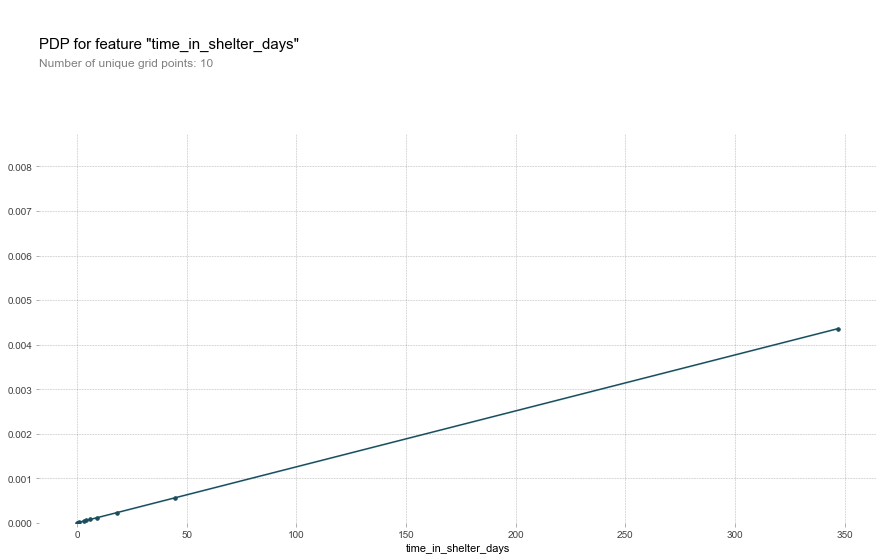

In [40]:
#Communicate results
feature = 'time_in_shelter_days'

isolate = pdp_isolate(
    model_gs,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)
pdp_plot(isolate, feature_name=feature)

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_inter_ax': <AxesSubplot:xlabel='intake_month', ylabel='outcome_month'>})

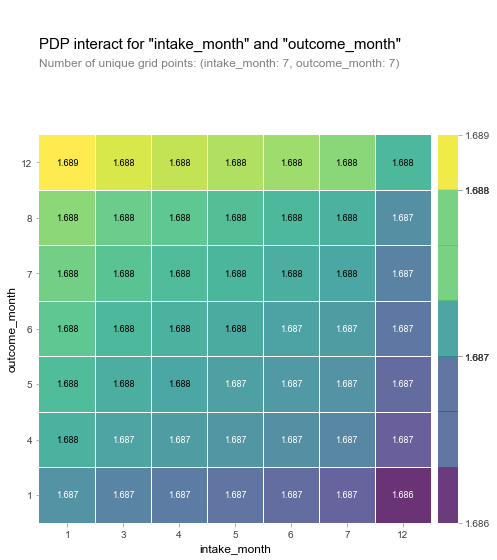

In [41]:
#Seeing if the age they are brought in and how long they are 
features = ['intake_month', 'outcome_month']

interact = pdp_interact(
    model_gs,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)
pdp_interact_plot(interact, plot_type='grid', feature_names=features)